# LASSO

### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_testing_fake.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

### Model Training and In-Sample Fitting

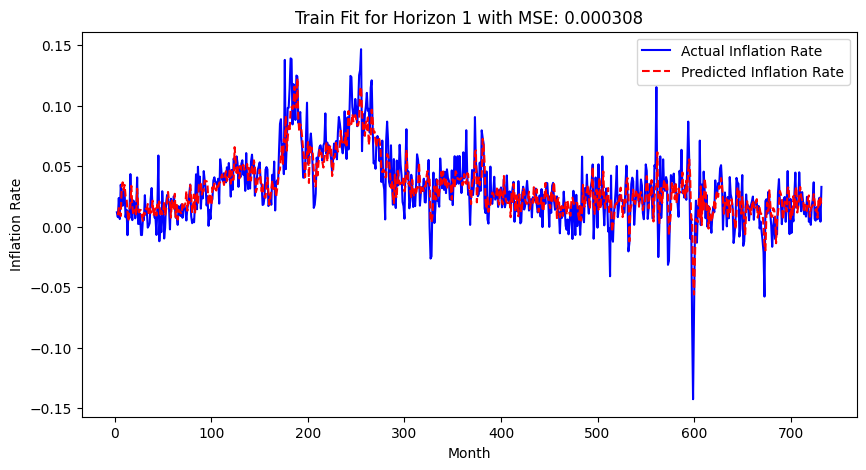

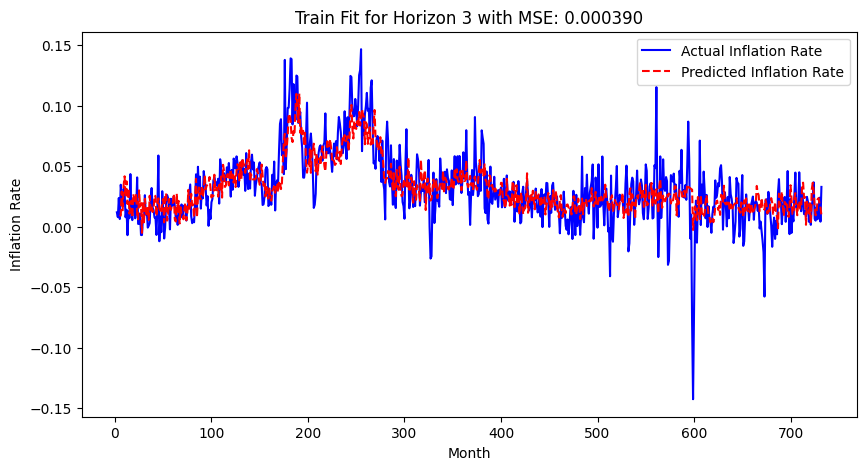

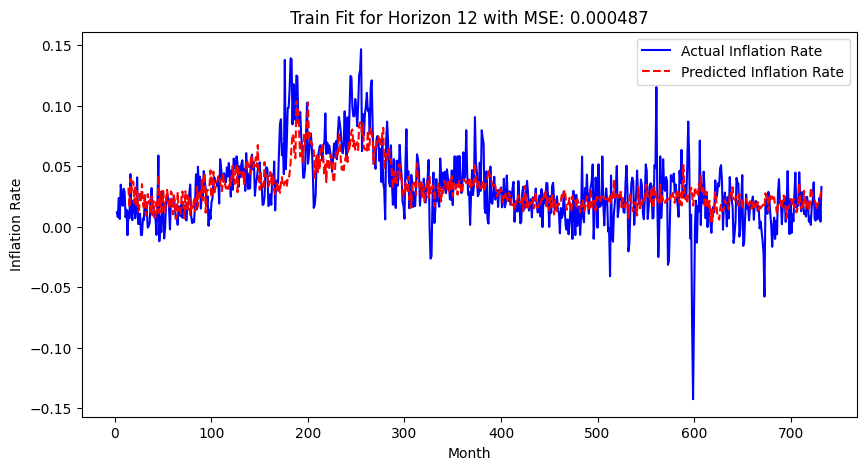

In [343]:
def prepare_data_for_lag(lag, train_inflation, predictors):
    # Create datasets of lagged inflation rates and other predictors
    X_inflation_lag = train_inflation.shift(lag).dropna()  # Lagged inflation rate
    X_predictors_lag = predictors.shift(lag).dropna()  # Lagged other predictors
    y = train_inflation.iloc[lag:]  # Current inflation rate

    # Combine lagged inflation rates and other predictors
    X = pd.concat([X_inflation_lag, X_predictors_lag], axis=1).iloc[:len(y), :]
    return X, y

alphas = np.logspace(-4, -0.5, 50)

def train_lasso_model(X, y, n_splits):
    # Use TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = LassoCV(alphas=alphas, cv=tscv, random_state=0, max_iter=10000).fit(X, y)
    return model

def plot_predictions(train_inflation_rate, y_pred, lag, title):
    plt.figure(figsize=(10, 5))
    y_pred_full = pd.Series([np.nan] * len(train_inflation_rate), index=train_inflation_rate.index)
    y_pred_full.iloc[lag:] = y_pred
    
    plt.plot(train_inflation_rate, label='Actual Inflation Rate', color='blue')
    plt.plot(y_pred_full, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

lags = [1, 3, 12]
models = {}
n_splits = 5

for lag in lags:
    X_lag, y_lag = prepare_data_for_lag(lag, train_inflation_rate, train_predictors_scaled)
    model = train_lasso_model(X_lag, y_lag, n_splits)
    models[lag] = model
    # Prediction
    y_pred = model.predict(X_lag)
    
    train_mse = mean_squared_error(y_lag, y_pred)
    
    # Plot
    plot_predictions(train_inflation_rate, y_pred, lag, f'Train Fit for Horizon {lag} with MSE: {train_mse:.6f}')

In [344]:
def print_model_details(model, description):
    print(f"Model description: {description}")
    print(f"Selected optimal alpha value: {model.alpha_:.6f}")
    print("Average cross-validation score of the model:", model.mse_path_.mean(axis=1).min())
    print("Model coefficients:")
    print(model.coef_)
    print("Model intercept:", model.intercept_)
    print("\n")

# Loop through all models and output detailed information
for lag, model in models.items():
    print_model_details(model, f"Horizon {lag} Lasso Model")

Model description: Horizon 1 Lasso Model
Selected optimal alpha value: 0.000720
Average cross-validation score of the model: 0.0005226419031054364
Model coefficients:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.05948106e-03
  3.44032144e-04 -3.40113692e-04  8.02950795e-04  0.00000000e+00
 -0.00000000e+00  6.99864104e-04  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -5.15667744e-05  0.00000000e+00  0.00000000e+00  3.00690960e-04
  1.02927202e-03  1.55709490e-04 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  5.04499074e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.04322107e-04
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.32798860e-04  4.57129447e-04  0.00000000e+00  4.91591250e-04
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.14215478e-04 -7.53431418e-05  1.1

### Pseudo Out-of-Sample Prediction

In [346]:
# Store each model's prediction results
test_predictions = {}
mse_scores = {}

for lag, model in models.items():
    # Extract the tail part of the training data to fulfill the lag requirement
    train_inflation_tail = train_inflation_rate[-lag:]
    train_predictors_tail = train_predictors_scaled.tail(lag)
    
    # Concatenate training tail and test data to create a full test dataset
    test_inflation_rate_full = pd.concat([train_inflation_tail, test_inflation_rate])
    test_predictors_full = pd.concat([train_predictors_tail, pd.DataFrame(test_predictors_scaled, index=test_predictors.index)])

    # Prepare data
    X_test, y_test_actual = prepare_data_for_lag(lag, test_inflation_rate_full, test_predictors_full)
    
    # Perform predictions
    y_pred = model.predict(X_test)
    test_predictions[lag] = y_pred
    
    # Calculate MSE
    mse = mean_squared_error(y_test_actual, y_pred)
    mse_scores[lag] = mse
    print(f"{lag}-month-ahead model out-of-sample MSE: {mse}")

1-month-ahead model out-of-sample MSE: 32.0235105131593
3-month-ahead model out-of-sample MSE: 34.016680538744694
12-month-ahead model out-of-sample MSE: 31.850931776687275


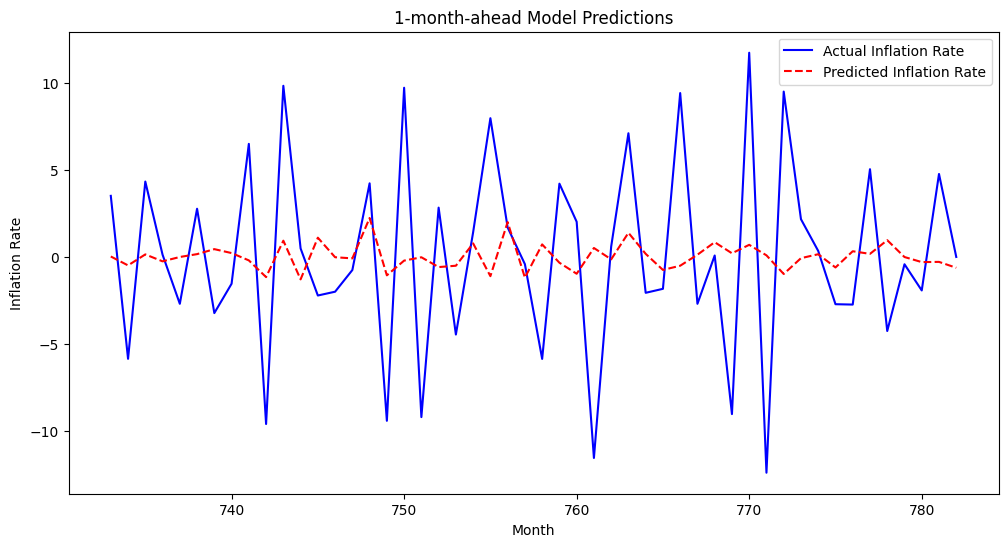

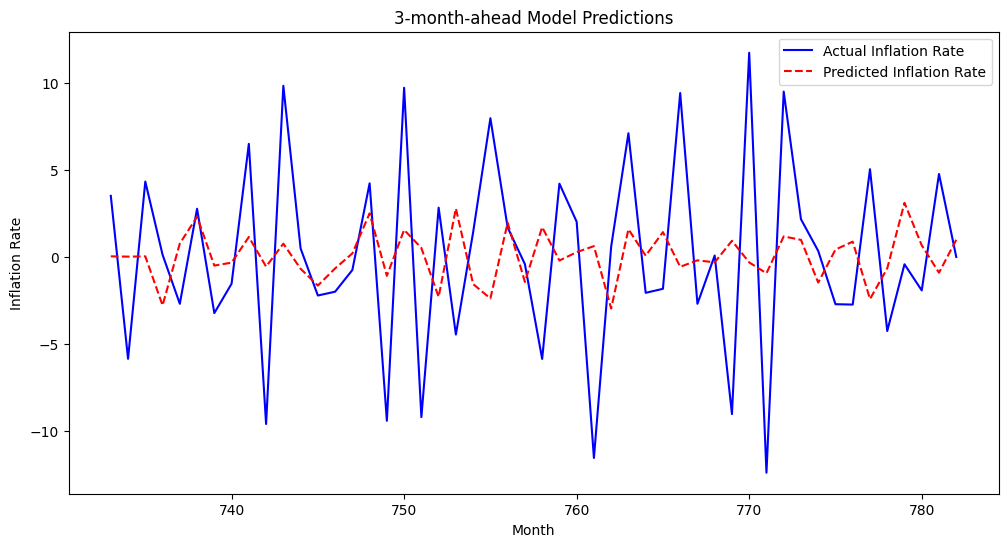

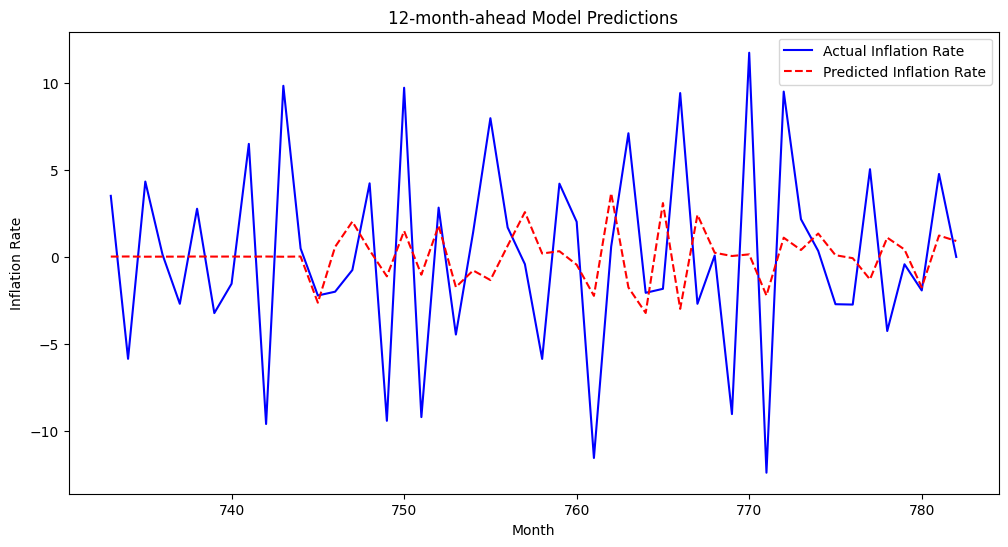

In [333]:
def plot_test_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual Inflation Rate', color='blue')
    plt.plot(y_true.index, y_pred, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

# Plot graphs for each model
for lag, y_pred in test_predictions.items():
    plot_test_predictions(test_inflation_rate, y_pred, f"{lag}-month-ahead Model Predictions")

## Adaptive LASSO

### Model Training and In-Sample Fitting

1-month lag model: MSE = 0.000482, Selected alpha = 0.053367


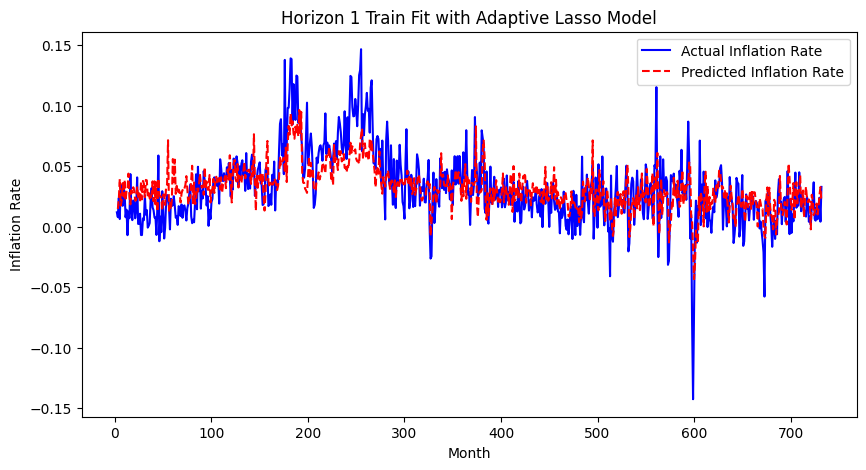

3-month lag model: MSE = 0.000457, Selected alpha = 0.008697


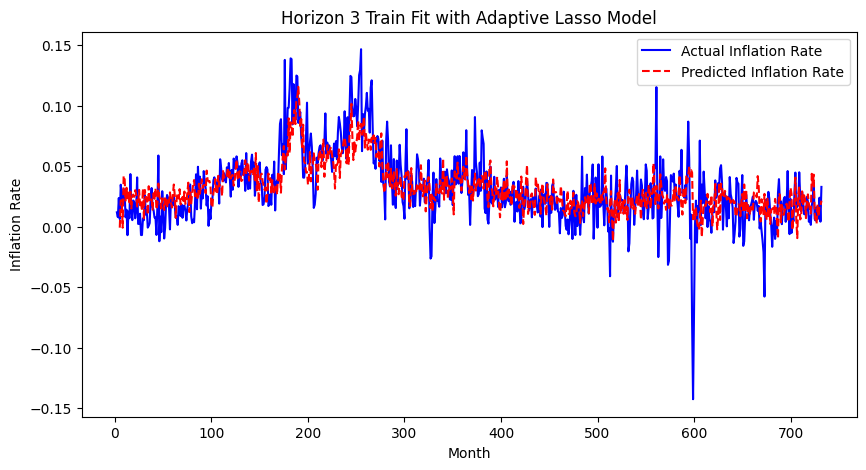

12-month lag model: MSE = 0.000548, Selected alpha = 0.020092


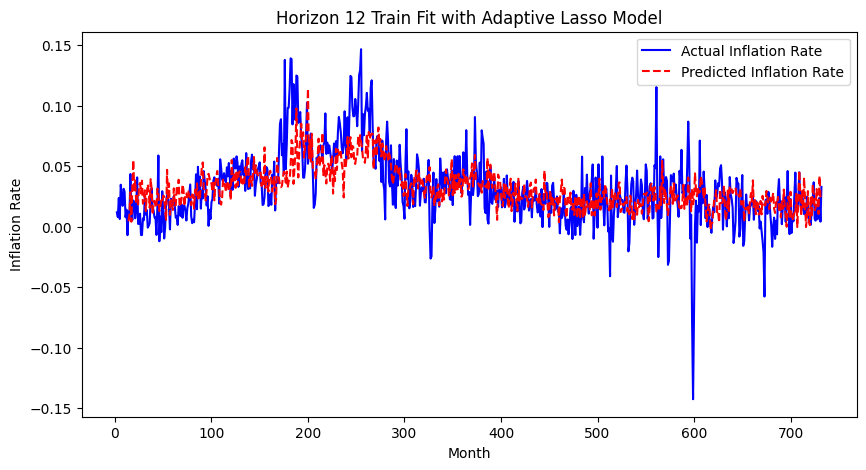

In [351]:
from sklearn.linear_model import LinearRegression

def get_ols_coefficients(X, y):
    # Fit an Ordinary Least Squares (OLS) regression and return the coefficients
    ols = LinearRegression().fit(X, y)
    return ols.coef_

def train_adaptive_lasso(X, y, weights, n_splits, alphas):
    # Apply weights to features
    X_weighted = X.multiply(weights, axis=1)  # Multiply features by weights

    # Use Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = LassoCV(alphas=alphas, cv=tscv, max_iter=100000, random_state=0,tol=0.005).fit(X_weighted, y)
    return model

# Define a range of alphas
alphas = np.logspace(-4, 2, 100)
models_adaptive = {}
mse_scores = {}
selected_alphas = {}

for lag in lags:
    X_lag, y_lag = prepare_data_for_lag(lag, train_inflation_rate, train_predictors)
    # Calculate weights (inverse of the absolute OLS coefficients)
    ols_coefficients = get_ols_coefficients(X_lag, y_lag)
    weights = 1 / np.abs(ols_coefficients)
    weights[np.isinf(weights)] = 1e8  # Handle infinite values when dividing by zero

    model_adaptive = train_adaptive_lasso(X_lag, y_lag, weights, n_splits, alphas)
    models_adaptive[lag] = model_adaptive
    
    y_pred_adaptive = model_adaptive.predict(X_lag.multiply(weights, axis=1))  # Apply the same weights to the predictors 
    mse = mean_squared_error(y_lag, y_pred_adaptive)
    mse_scores[lag] = mse
    
    selected_alphas[lag] = model_adaptive.alpha_
    
    # Print MSE and selected alpha for each model
    print(f"{lag}-month lag model: MSE = {mse:.6f}, Selected alpha = {model_adaptive.alpha_:.6f}")

    # Visualize predictions alongside actual inflation rates
    plot_predictions(train_inflation_rate, y_pred_adaptive, lag, f'Horizon {lag} Train Fit with Adaptive Lasso Model')

### Pseudo Out-of-Sample Prediction

In [335]:
for lag, model in models_adaptive.items():
    train_inflation_tail = train_inflation_rate[-lag:]
    train_predictors_tail = train_predictors.tail(lag)
    test_inflation_rate_full = pd.concat([train_inflation_tail, test_inflation_rate])
    test_predictors_full = pd.concat([train_predictors_tail, test_predictors])

    X_test, y_test_actual = prepare_data_for_lag(lag, test_inflation_rate_full, test_predictors_full)
    
    y_pred_adaptive = model_adaptive.predict(X_test.multiply(weights, axis=1))
    test_predictions[lag] = y_pred_adaptive
    
    mse = mean_squared_error(y_test_actual, y_pred_adaptive)
    mse_scores[lag] = mse
    print(f"{lag}-month-ahead model out-of-sample MSE: {mse}")

1-month-ahead model out-of-sample MSE: 34.47209807302218
3-month-ahead model out-of-sample MSE: 32.74817450521915
12-month-ahead model out-of-sample MSE: 31.233149226999977


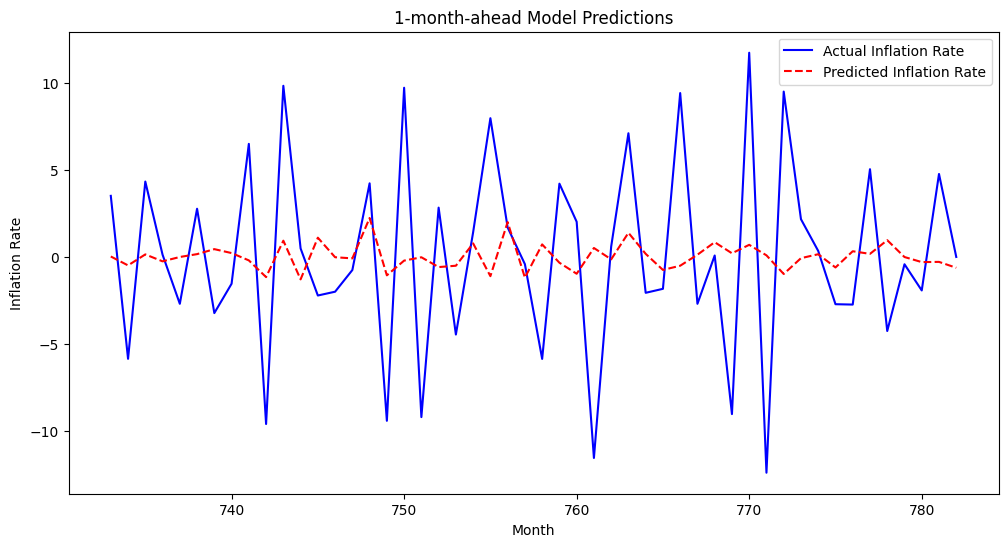

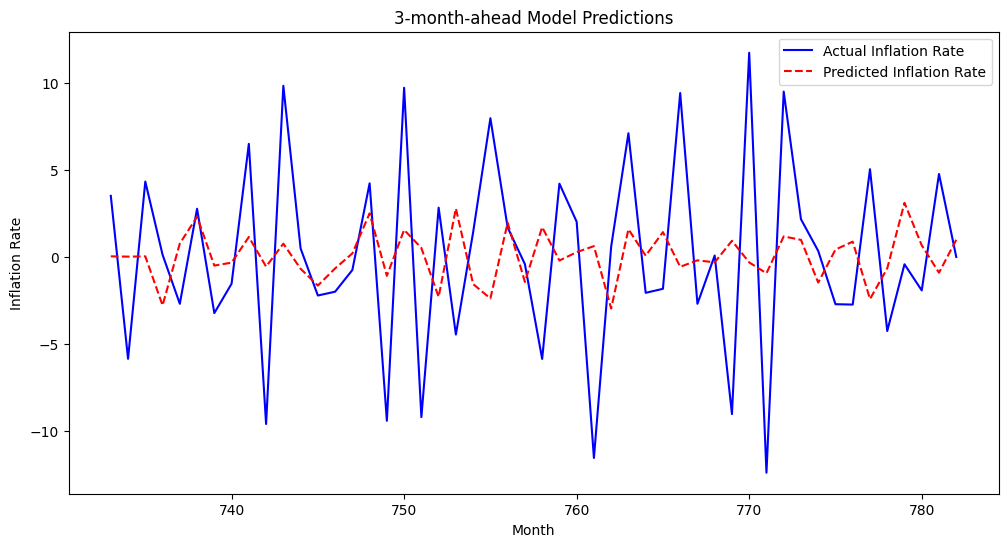

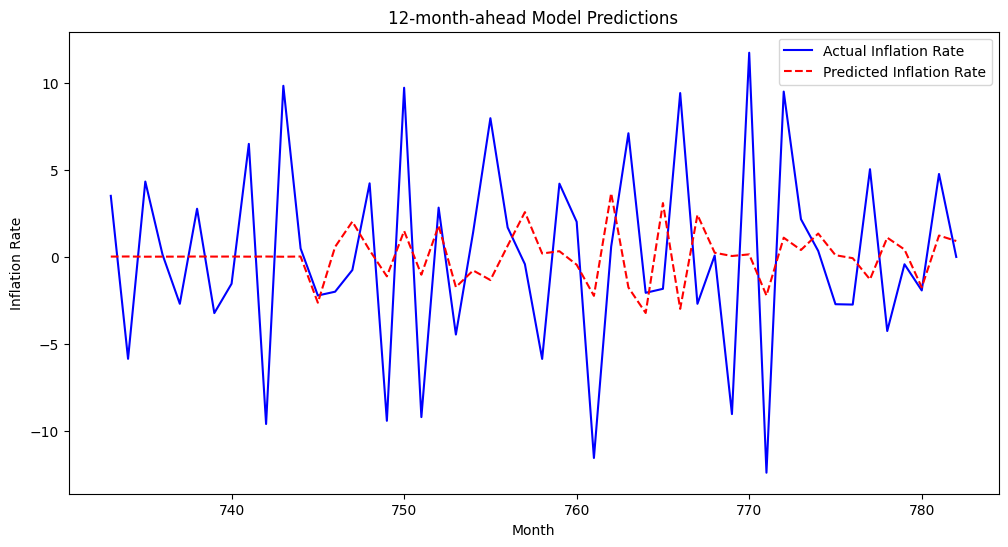

In [348]:
for lag, y_pred_adaptive in test_predictions.items():
    plot_test_predictions(test_inflation_rate, y_pred_adaptive, f"{lag}-month-ahead Model Predictions")